In [1]:
import os,sys,time
import numpy as np
import torch

In [2]:
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'


In [3]:
import voxelmorph as vxm
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import importlib

In [4]:
file='/home-local/rudravg/registration_stress_test/512/image_pairs_v2.txt'
train_files=vxm.py.utils.read_file_list(file)
val_file='/home-local/rudravg/registration_stress_test/512/image_pairs_val_v2.txt'
val_files=vxm.py.utils.read_file_list(val_file)

In [5]:
len(train_files), train_files[0],len(val_files), val_files[0]

(4800,
 '/home-local/rudravg/registration_stress_test/512/image1_0.npy',
 600,
 '/home-local/rudravg/registration_stress_test/512/image1_2400.npy')

In [6]:
generator=vxm.generators.scan_to_scan(train_files)
val_generator=vxm.generators.scan_to_scan(train_files)

In [7]:
generator,val_generator

(<generator object scan_to_scan at 0x7f30b3d374c0>,
 <generator object scan_to_scan at 0x7f30b3d37600>)

In [8]:
inshape=next(generator)[0][0].shape[1:-1]
inshape

(512, 512)

In [9]:
batch=next(generator)
batch[0][0].shape

(1, 512, 512, 1)

In [10]:
model=vxm.networks.VxmDense(inshape=inshape)

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
model

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [12]:
model.to('cuda')
model.train()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
image_loss_func=vxm.losses.MSE().loss 
losses=[image_loss_func]
weights=[1]

In [14]:
losses += [vxm.losses.Grad('l2',loss_mult=2).loss]
weights += [1]

In [15]:
losses

[<bound method MSE.loss of <voxelmorph.torch.losses.MSE object at 0x7f30b3be89b0>>,
 <bound method Grad.loss of <voxelmorph.torch.losses.Grad object at 0x7f30b3c43440>>]

In [16]:
weights

[1, 1]

In [17]:
inputs, y_true = next(generator)
inputs1 = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in inputs]
y_true1 = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in y_true]
inputs1[0].shape, y_true1[0].shape,inputs1[1].shape

(torch.Size([1, 1, 512, 512]),
 torch.Size([1, 1, 512, 512]),
 torch.Size([1, 1, 512, 512]))

In [18]:
weights[1]

1

In [19]:
epoch_loss_final=[]
val_loss_final=[]
for epoch in range(30):
    model.train()
    model.save(f'512_models/model_epoch_{epoch}.pt')
    epoch_loss=[]
    epoch_total_loss=[]
    epoch_step_time=[]
    val_loss=[]

    for step in range(2400):
        step_time=time.time()
        inputs, y_true = next(generator)
        inputs = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in inputs]
        y_true = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in y_true]
        y_pred=model(*inputs)
        loss=0
        loss_list=[]
        for n,loss_function in enumerate(losses):
            curr_loss=loss_function(y_true[0],y_pred[0])*weights[n]
            loss_list.append(curr_loss.item())
            loss+=curr_loss
            #print(loss.item())
        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_step_time.append(time.time()-step_time)
    print(f'Epoch {epoch+1} Loss: {np.mean(epoch_total_loss)}')
    epoch_loss_final.append(np.mean(epoch_total_loss))
    print(f'Epoch {epoch+1} Losses: {np.mean(epoch_loss, axis=0)}')
    print(f'Epoch {epoch+1} Step Time: {np.mean(epoch_step_time)}')
    with torch.no_grad():
        model.eval()
        for step in range(300):
            inputs, y_true = next(val_generator)
            inputs = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in inputs]
            y_true = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in y_true]
            y_pred=model(*inputs)
            loss=0
            for n,loss_function in enumerate(losses):
                curr_loss=loss_function(y_true[0],y_pred[0])*weights[n]
                loss+=curr_loss
            val_loss.append(loss.item())
        print(f'Epoch {epoch+1} Val Loss: {np.mean(val_loss)}')
        val_loss_final.append(np.mean(val_loss))
model.save('512_models/final_model.pt')

Epoch 1 Loss: 0.029093208800574453
Epoch 1 Losses: [0.02793362 0.00115959]
Epoch 1 Step Time: 0.031727145413557686
Epoch 1 Val Loss: 0.02065259230012695
Epoch 2 Loss: 0.019700766516907605
Epoch 2 Losses: [0.01847533 0.00122544]
Epoch 2 Step Time: 0.031343531310558316
Epoch 2 Val Loss: 0.01559362317280223
Epoch 3 Loss: 0.014875920045014937
Epoch 3 Losses: [0.01347767 0.00139825]
Epoch 3 Step Time: 0.031180254419644674
Epoch 3 Val Loss: 0.013468787343396495
Epoch 4 Loss: 0.013519092868203492
Epoch 4 Losses: [0.0121616 0.0013575]
Epoch 4 Step Time: 0.031226246058940886
Epoch 4 Val Loss: 0.012373266686530163
Epoch 5 Loss: 0.013473123099198953
Epoch 5 Losses: [0.01206516 0.00140796]
Epoch 5 Step Time: 0.031297121147314706
Epoch 5 Val Loss: 0.012443209561364105
Epoch 6 Loss: 0.013290286330302478
Epoch 6 Losses: [0.0119246  0.00136569]
Epoch 6 Step Time: 0.03155037224292755
Epoch 6 Val Loss: 0.012189752080012113
Epoch 7 Loss: 0.012229305098881014
Epoch 7 Losses: [0.01081832 0.00141098]
Epoch 

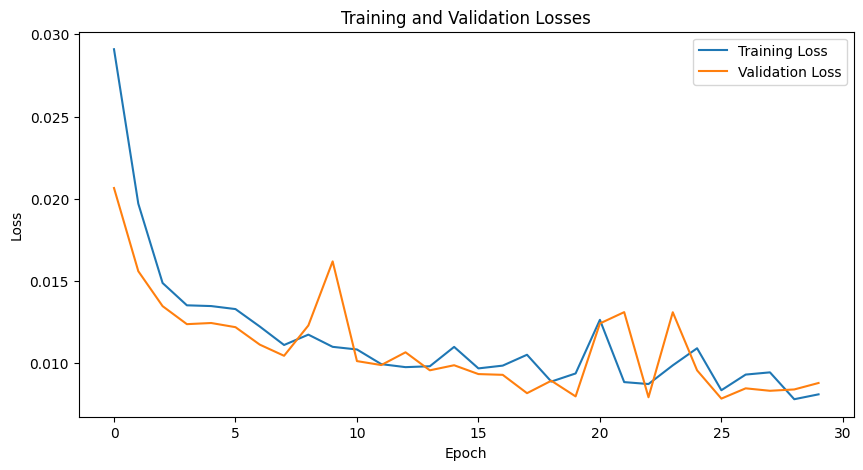

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_loss_final, label='Training Loss')
plt.plot(val_loss_final, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
min(val_loss_final), val_loss_final.index(min(val_loss_final)),min(epoch_loss_final), epoch_loss_final.index(min(epoch_loss_final))

(0.007845486187531302, 25, 0.007808136530948104, 28)

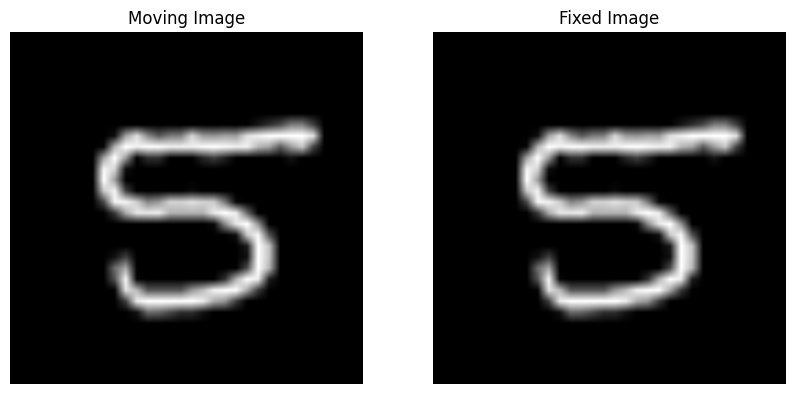

In [97]:
moving_file='/home-local/rudravg/registration_stress_test/512/image1_2685.npy'
moving_file='/home-local/rudravg/registration_stress_test/512/image1_2685.npy'
model_path='/nfs2/forGaurav/yesbackup/DAPI_reg/vxl_morph/voxelmorph-dev/512_models/model_epoch_28.pt'
# Load the images
moving_image = np.load(moving_file)
fixed_image = np.load(fixed_file)

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the moving image
axs[0].imshow(moving_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Moving Image')

# Plot the fixed image
axs[1].imshow(fixed_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Fixed Image')

# Display the plot
plt.show()


In [98]:
fixed_image.min(),fixed_image.max(),moving_image.min(),moving_image.max()

(0.0, 1.0, 0.0, 1.0)

In [99]:
device = 'cuda'
moving=vxm.py.utils.load_volfile(moving_file,add_batch_axis=True,add_feat_axis=True)
fixed,fixed_affine=vxm.py.utils.load_volfile(fixed_file,add_batch_axis=True,add_feat_axis=True,ret_affine=True)

In [100]:
test_model=vxm.networks.VxmDense.load(model_path, device)
test_model.to(device)
test_model.eval()

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [101]:
input_moving=torch.from_numpy(moving).to(device).float().permute(0,3,1,2)
input_fixed=torch.from_numpy(fixed).to(device).float().permute(0,3,1,2)


In [102]:
moved,warp=test_model(input_moving,input_fixed,registration=True)


In [103]:
moved_img=moved.detach().cpu().numpy().squeeze()
moved_img.shape
warped=warp.detach().cpu().numpy().squeeze()
warped.shape

(2, 512, 512)

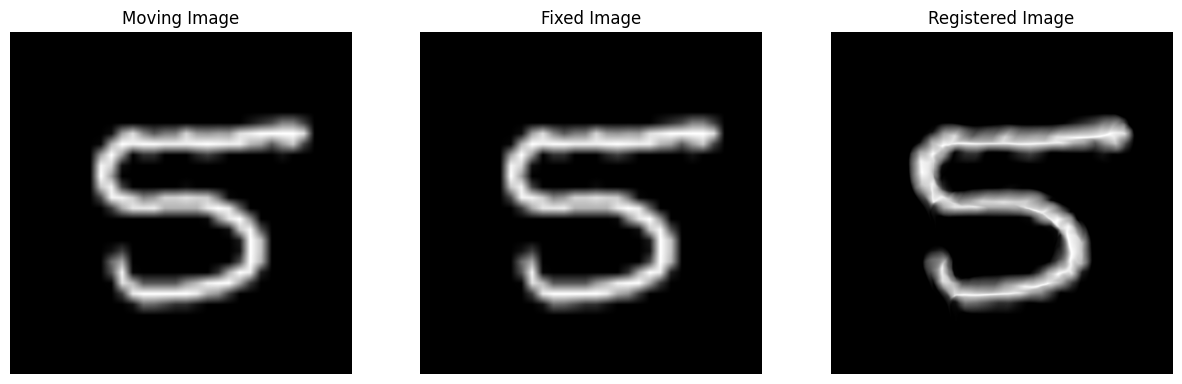

In [104]:
# Load the moving and fixed images
moving_image = np.load(moving_file)
fixed_image = np.load(fixed_file)

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the moving image
axs[0].imshow(moving_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Moving Image')

# Plot the fixed image
axs[1].imshow(fixed_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Fixed Image')

# Plot the registered image
axs[2].imshow(moved_img, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Registered Image')

# Display the plot
plt.show()

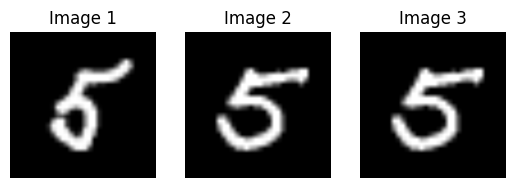

In [146]:
images,yimage=next(generator)
img1=images[0][0].squeeze()
img2=images[1][0].squeeze()
img3=yimage[0].squeeze()
img1.shape,img2.shape,img3.shape    
# Plot the first image
plt.subplot(1, 3, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.title('Image 1')

# Plot the second image
plt.subplot(1, 3, 2)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.title('Image 2')

# Plot the third image
plt.subplot(1, 3, 3)
plt.imshow(img3, cmap='gray')
plt.axis('off')
plt.title('Image 3')

# Display the plot
plt.show()


In [127]:
list_item=np.asarray(images).shape
list_item

(2, 1, 512, 512, 1)

In [147]:
test_generator=vxm.generators.scan_to_scan(val_files,batch_size=10)

In [152]:
new_list_item=next(test_generator)
len(new_list_item),new_list_item[0][0].shape,new_list_item[1][0].shape

(2, (10, 512, 512, 1), (10, 512, 512, 1))

In [158]:
new_list_item[0][0][4].shape

(512, 512, 1)

In [159]:
#The input to the model is a list of two images of shape (batch_size, height, width, 1).
#The output of the model is a list of two images of shape (batch_size, height, width, 1) and a transformation field of shape (batch_size, height, width, 2).
#So we have to concatenate the two images into a single tensor of shape (batch_size, 2, height, width, 1) and then pass it to the model.
#So it will be for each batch, we will have 2 images as the input.

In [164]:
inputs, y_true = next(generator)
inputs = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in inputs]
y_true = [torch.from_numpy(d).to('cuda').float().permute(0,3,1,2) for d in y_true]

In [167]:
inputs[1].shape

torch.Size([1, 1, 512, 512])

In [169]:
y_true[0].shape

torch.Size([1, 1, 512, 512])

In [170]:
len(inputs),inputs[0].shape,inputs[1].shape

(2, torch.Size([1, 1, 512, 512]), torch.Size([1, 1, 512, 512]))

In [171]:
len(y_true),y_true[0].shape

(1, torch.Size([1, 1, 512, 512]))